<h1><center>Divvy Bikeshare Data Exploration</center></h1>

 <img src="http://jftrumm.com/wp-content/uploads/2015/04/2015-04-19-18.00.46.jpg" width ="600">





I will be working with the Divvy rides dataset from March 2016 to October 2016. This data was released by Divvy and includes the starttime, stoptime, starting location, ending location and usertype. It also includes the gender, bike id, station id, and trip id, but I will not be focusing on those attributes in this analysis. I chose to only include the Spring to Fall data to avoid any irregulariites because of winter and it's accompanying drop in tempurates and tourism.

The data needed almost no cleaning/restructuring and the only attributes with a significant number of values missing were in the gender and birthyear columns, which I intended on omitting any way. There are a number of ways to anaylyze the data, but I chose to focus on the usage patterns between Subscribers(People who pay a yearly fee) and Customers(People who paid for a one way trip, or daily pass). The data did not differentiate between daily/one-way purchases, which prevented me from drawing distinctions between those two groups as well as preventing me from analyzing revuenes as they relate to the different categories of riders.

Key Term: First-Mile/Last-Mile describes the issue of how people get to and from public transit stops. Most people won't travel more than a quarter mile to take the train/bus. 


## Pre-processing:

I created a time_hour column(0-24) and a weekday column to be able to compare peak use times between user types. I also checked which columns were missing data. As I mentioned above, the only columns missing data were ones I wasn't planning on using.



In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import *
import matplotlib.style as style
%matplotlib inline
style.use('fivethirtyeight')

divvy = pd.read_csv("Chicago-Divvy-2016.csv")






In [232]:
# convert seconds to minutes
divvy['tripduration'] = divvy['tripduration']//60

# add a time_hour column
divvy['time_hour'] = divvy['starttime'].apply(lambda x: datetime.strptime(x,"%m/%d/%Y %H:%M").strftime('%H'))

# add a day column
divvy['weekday'] = divvy['starttime'].apply(lambda x: pd.to_datetime(x)).dt.weekday_name

# Sort weekday column
divvy['weekday'] = pd.Categorical(divvy['weekday'], categories=['Sunday', 'Saturday', 'Friday', 'Thursday', 'Wednesday', 'Tuesday', 'Monday'], ordered=True)


divvy.head(5)



,trip_id,starttime,stoptime,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,birthyear,time_hour,weekday
0,9080545,3/31/2016 23:30,3/31/2016 23:46,2295,15,156,Clark St & Wellington Ave,166,Ashland Ave & Wrightwood Ave,Subscriber,Male,1990.0,23,Thursday
1,9080521,3/31/2016 22:59,3/31/2016 23:02,3439,3,259,California Ave & Francis Pl,276,California Ave & North Ave,Subscriber,Male,1974.0,22,Thursday
2,9080479,3/31/2016 22:24,3/31/2016 22:26,4337,2,344,Ravenswood Ave & Lawrence Ave,242,Damen Ave & Leland Ave,Subscriber,Female,1992.0,22,Thursday
3,9080475,3/31/2016 22:22,3/31/2016 22:41,3760,19,318,Southport Ave & Irving Park Rd,458,Broadway & Thorndale Ave,Subscriber,Female,1979.0,22,Thursday
4,9080443,3/31/2016 22:08,3/31/2016 22:19,1270,10,345,Lake Park Ave & 56th St,426,Ellis Ave & 60th St,Subscriber,Female,1997.0,22,Thursday


In [233]:
len(divvy)

72131

In [234]:
#See how many data points I'm missing
missing_value = divvy.isnull().sum()
missing_value[:]

trip_id                  0
starttime                0
stoptime                 0
bikeid                   0
tripduration             0
from_station_id          0
from_station_name        0
to_station_id            0
to_station_name          0
usertype                 0
gender               17154
birthyear            17145
time_hour                0
weekday                  0
dtype: int64

# Analytic Questions


### Comparing Trip Duration diferences between User Types

In reviewing the measures of central tendency of trip duration, the results match my expecrted outcome: Subscribers are locals who use the system for short trips or as a First-Mile/Last-Mile option while Customers tend to be tourists who use the system to tour the city or to reach tourist destinations that are not well served by public transportation. The median Customer trip was 13 minutes longer than the median Subscriber trip.

The data itself has a large number of outliers, but the median appears to be a great representation of the middlepoint in both the overall dataset and with respects to the Subsriber and Customer segments.

In [235]:
print("Median", np.median(divvy['tripduration']))
divvy.tripduration.describe()

Median 11.0


count    72131.000000
mean        16.071287
std         32.849716
min          1.000000
25%          6.000000
50%         11.000000
75%         19.000000
max       1439.000000
Name: tripduration, dtype: float64

In [236]:
print("Customer Median", np.median(divvy[divvy['usertype']=='Customer'].tripduration))
print("Subscriber Median", np.median(divvy[divvy['usertype']=='Subscriber'].tripduration))
divvy[['usertype', 'tripduration']].groupby('usertype').describe()

Customer Median 22.0
Subscriber Median 9.0


tripduration                                                     
                  count       mean        std  min   25%   50%   75%     max
usertype                                                                    
Customer        17149.0  30.488250  52.684454  1.0  15.0  22.0  31.0  1439.0
Subscriber      54982.0  11.574606  21.562416  1.0   5.0   9.0  15.0  1272.0

The visual representation of the Subscriber and Customer datasets show the difference in trip duration more clearly, with the median Customer trip length falling near the right tail end of the Subscriber trip lenghts. Very few Subscribers seem to ride for more than 30 minutes, while we see a meaningful number of Customer trips extending all the way up to an hour/hour+.

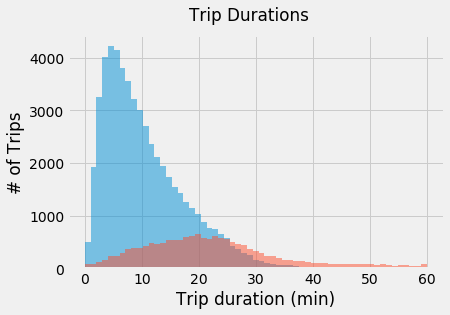

In [237]:
import plotly as py  
import matplotlib.pyplot as plt

def titles(head,x,y):
    plt.suptitle(head)
    plt.xlabel(x)
    plt.ylabel(y)


histogram=plt.figure()

x = divvy[divvy['usertype']=='Subscriber'].tripduration
y = divvy[divvy['usertype']=='Customer'].tripduration

bins = np.linspace(0, 60, 60)

plt.hist(x, bins, alpha=0.5)
plt.hist(y, bins, alpha=0.5)
titles('Trip Durations', 'Trip duration (min)', '# of Trips')


plt.show()


### Station Usage differences between User Types.

First, we'll look at the ratio of Subscribers to Customers and then analyze the station origiation and destination volumes. 

No surprises with the breakdown between Subscribers and Customers as, even during the tourist seasons, we would expect the trips taken to overwhelmingly be by Subscribers. We can see Subscribers make up 75% of the trips during our study period.

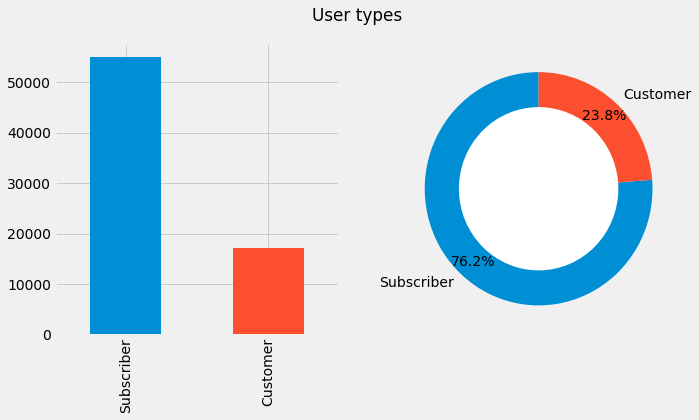

In [238]:
#Create grid for side by side
fig, axs = plt.subplots(1,2)
titles('User types', "","")
divvy.usertype.value_counts().plot(kind='bar'
    , title=""
    , ax=axs[0]
    , figsize = (10,5))


type_counts = divvy.usertype.value_counts()
labels = ['Subscriber', 'Customer']


# Creat pie chart
plt.pie(type_counts
        , labels=labels 
        , autopct='%1.1f%%'
        , startangle=90
        , pctdistance=0.85)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


plt.show()


Moving on to Origination and destination, it's somewhat suprising to see the Streeter & Grand station come out as by far the most used station, nearly doubling the popularity of the next closest station.

The Streeter & Grand location is located at the entrance to Navy Pier which is the number one tourist destination in Chicago. It's well served by a bus route and a trolley, is almost entirely avoided by locals, and has a low density of residential and commercial space compared to its surrounding neighborhoods.

The origin and destination locations match up well, which we would expect; However, it is surprising to see the top 30 stations dominated so heavily by stations in the Loop and River North neighborhoods. The first station that is outside of the Loop/River North is Clark/Armitage in Lincoln Park at #28. 

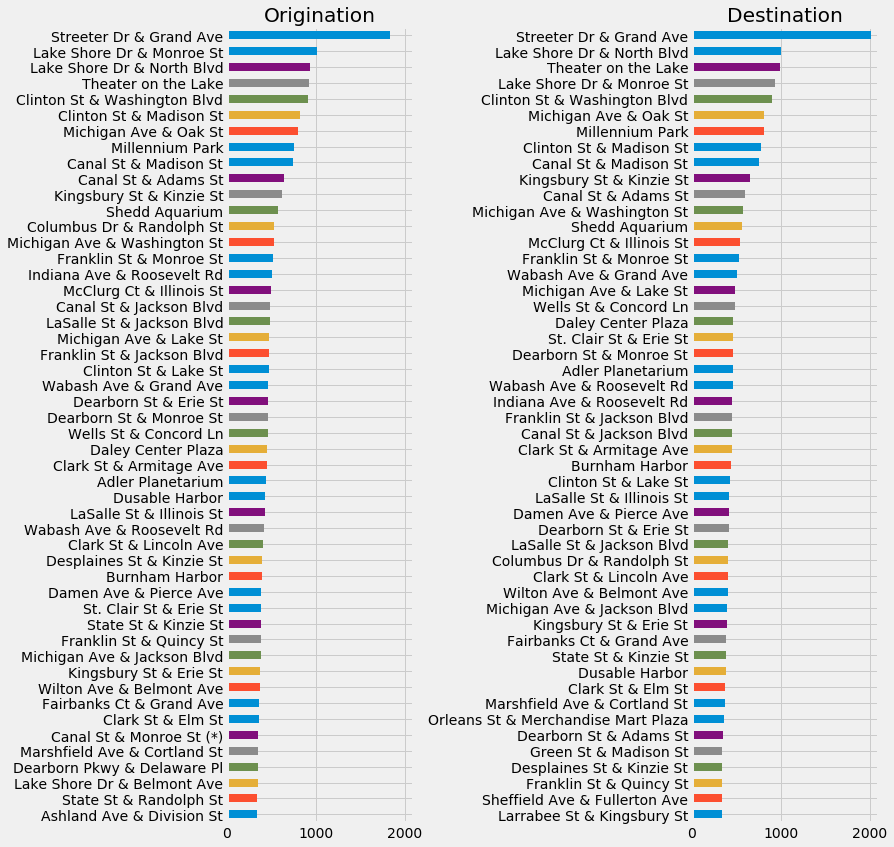

In [239]:
#Create grid for side by side
fig, axs = plt.subplots(1,2)

#Add padding to reduce overlap
plt.tight_layout(pad=0, w_pad=9, h_pad=1.0)



ax1 = divvy.from_station_name.value_counts().head(50).sort_values().plot(
          kind='barh'
        , title="Origination"
        , ax=axs[0]
        , figsize = (10,12))

ax2 = divvy.to_station_name.value_counts().head(50).sort_values().plot(
        kind='barh'
        , title = "Destination"
        , ax=axs[1]
        , figsize = (10,12))


plt.show(ax1.set_xlim([0, 2100]), ax2.set_xlim([0, 2100]))

We'll list the top 20 overall station origination and destinations grouped by usertype, and then listed out by usertype to see how the different user patterns might have affected the popularity of the anlaysis above.  

The top spot above was the Streeter and Grand station, and it's the top spot here as well, but shockingly, it's driven almost entirely by Customers. It's not surpising that mostly Customers use this station, what is suprising is that Customers trips only make up ~25% of the overall trips, yet they use the Streeter/Grand station so much it dwarfs the other locations. I would have expected the most popular station to be driven by Subsribers, or a location in the Loop that was largely used by Subscribers and Customers alike (e.g Willis tower or Michigan Avenue stations).

Of the top 20 locations grouped by usertype, 7 are most popluar customer locations. Again, this is despite only making up ~25% of the total trips which suggests Customers tend to mostly use the same stations.

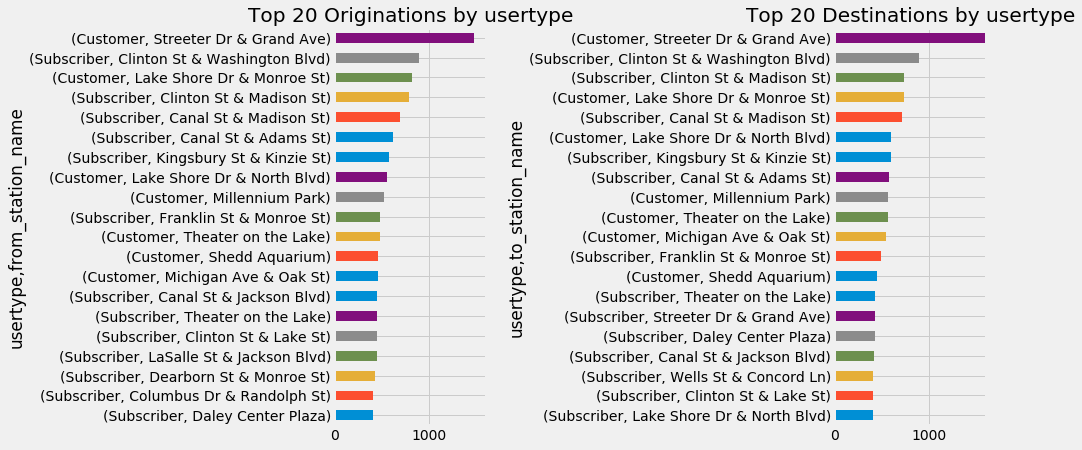

In [240]:
#Create grid for side by side
fig, axs = plt.subplots(1,2)

#Add padding to reduce overlap
plt.tight_layout(pad=0, w_pad=12, h_pad=1.0)


ax1 = divvy.groupby('usertype')['from_station_name'].value_counts().nlargest(20).sort_values().plot(
      kind='barH'
    , title="Top 20 Originations by usertype"
    , ax=axs[0]
    , figsize = (10,6))

ax2 = divvy.groupby('usertype')['to_station_name'].value_counts().nlargest(20).sort_values().plot(
      kind='barH'
    , title="Top 20 Destinations by usertype"
    , ax=axs[1]
    , figsize = (10,6))


plt.show(ax1.set_xlim([0, 1600]), ax2.set_xlim([0, 1600]))


Comparing the top 20 locations by Usertype and Orignation/Destination, we can see the most popular Customer locations are dominated by tourist destinations while the most popular subscriber destinations are dominated by stations in the Loop. 

We also see that the Clark/Armitage station referenced above is relatively more popular with Customers than Subscribers, which gives the impression that the Divvy system is used by Subscribers primarily as a First-Mile/Last-Mile option and potentially getting to/from work as the median trip is 9 min which limits the median trip range to just a few miles.

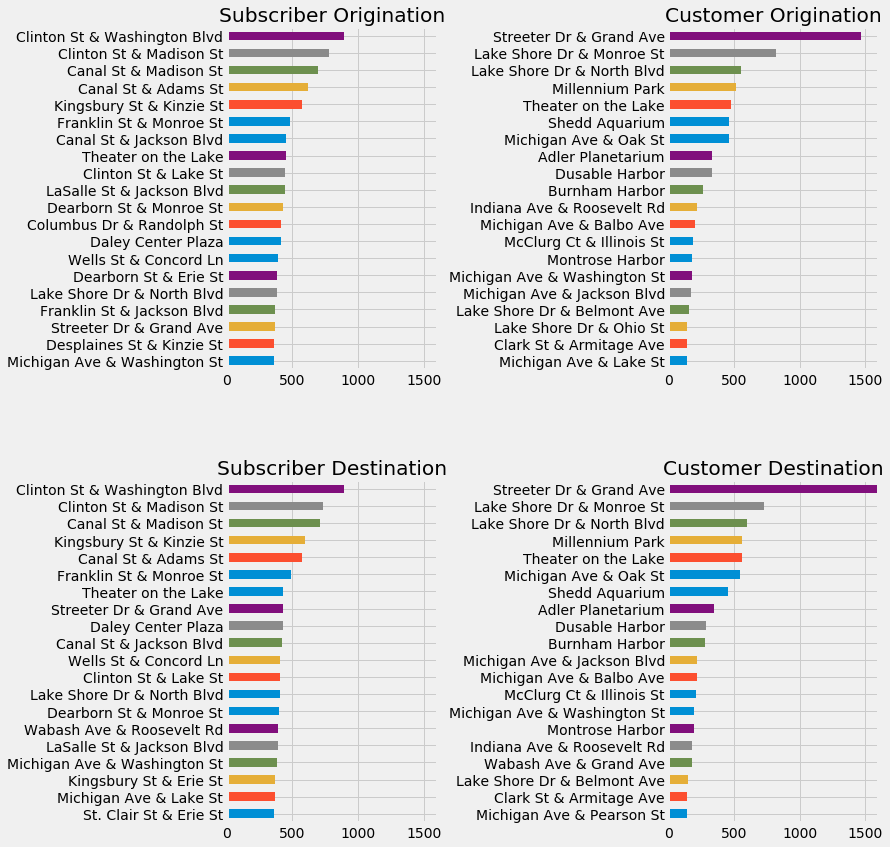

In [241]:
#Create grid for side by side
fig, axs = plt.subplots(2,2)
#Add padding to reduce overlap
plt.tight_layout(pad=0, w_pad=7, h_pad=1.0)


ax1 = divvy[divvy['usertype']=="Subscriber"].from_station_name.value_counts().head(20).sort_values().plot(
      kind='barh'
    , title="Subscriber Origination" 
    , ax=axs[0,0]
    , figsize = (10,12))

ax2 = divvy[divvy['usertype']=="Subscriber"].to_station_name.value_counts().head(20).sort_values().plot(
      kind='barh'
    , title = "Subscriber Destination"
    , ax=axs[1,0]
    , figsize = (10,12))

ax3 = divvy[divvy['usertype']=="Customer"].from_station_name.value_counts().head(20).sort_values().plot(
      kind='barh'
    , title="Customer Origination"
    , ax=axs[0,1]
    , figsize = (10,12))

ax4 = divvy[divvy['usertype']=="Customer"].to_station_name.value_counts().head(20).sort_values().plot(
      kind='barh'
    , title = "Customer Destination"
    , ax=axs[1,1]
    , figsize = (10,12))


def graph_limits(x):
    try:
        plt.show(ax1.set_xlim([0, x]), ax2.set_xlim([0, x]),ax3.set_xlim([0, x]),ax4.set_xlim([0, x]))
    except:
        pass
    

graph_limits(1600)


### Usage patterns by Day/Hour by User Type.

We've seen to above that Subscribers are locals that use Divvy as a First-Mile/Last-Mile option and Customers are tourists who use Divvy to visit tourist destinations. To confirm these usage patterns we would expect Subscribers to use Divvy during the morning and evening commutes with a smaller peak around lunchtime and for Customers to primarily use the system on the weekends.

The peak time for Divvy use during the Tuesday evening rush hour and evening rush hour is the most popular timeframe overall. 

When we look at the time frames broken down by usertype, it matches our expectations that Subscribers are driving the morning/evening and lunchtime trip volume, while Customer use is limited mostly to the weekends. This makes it even more extraoridnary that the most popular location by usertype is the Navy Pier station despite Customers primarily using the system on the weekends.

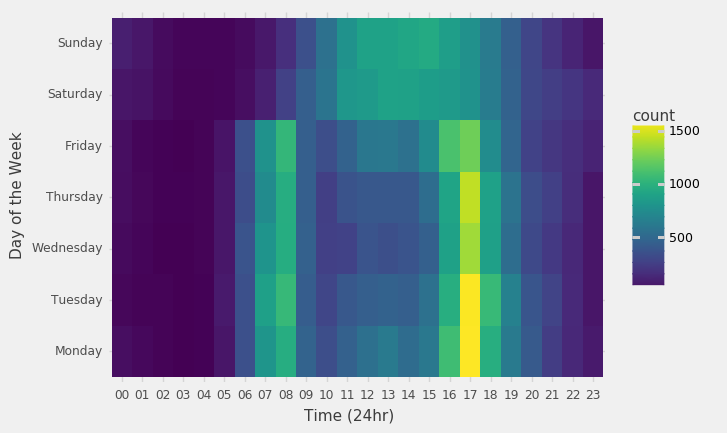

<ggplot: (311354737)>

In [242]:
#Re-sort data set to start at Monday
divvy['weekday'] = pd.Categorical(divvy['weekday']
                , categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
                , ordered=True)

(ggplot(divvy)
     + aes('time_hour', 'weekday')
     + geom_bin2d()
     + xlab("Time (24hr)")
     + ylab("Day of the Week")
     + theme_538())
     

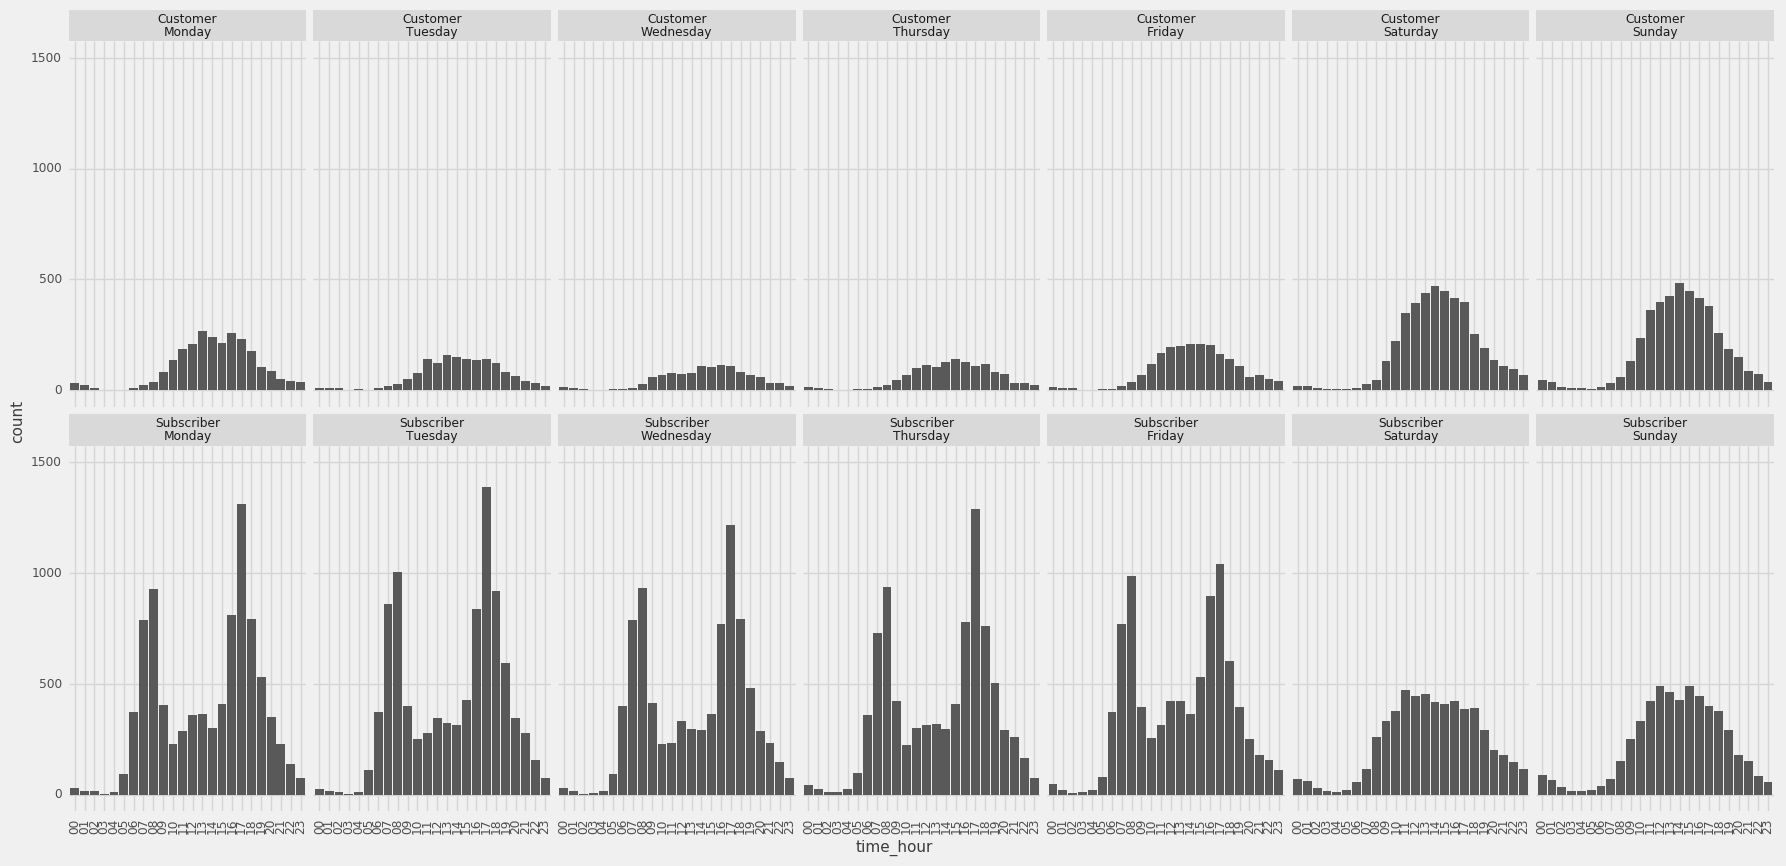

<ggplot: (-9223372036547383857)>

In [243]:
(ggplot(divvy)
    +aes('time_hour')
    + facet_wrap('~usertype+weekday',ncol = 7)
    + ylim(0,1500) 
    + theme_538()
    + theme(figure_size=(22, 10), axis_text_x=element_text(rotation=90))
    + geom_bar())

     




Subscribers and Customers have different usage patterns overall: Subscribers take more trips during rush hour and in the loop, and Subscriber trips outnumber Customer trips by 3 to 1. On the weekends, Subscribers only account for 56% of trips. 

On the Weekends, the top 20 origniations and destinations for Subscribers shifts to largely stations in the residential neighborhoods surrounding the loop and to some of the more popular tourist attractions. The usage pattern by Customers on the weekends is consistent with the overall sample.

Even though the Subscribers patterns change on the weekends, their median trip length stays at half of Customers trip length. Without gps bike data or station gps coordinates, it's impossible to ascertain why Customers take longer trips than Subscribers.

           tripduration                                                     
                  count       mean        std  min   25%   50%   75%     max
usertype                                                                    
Customer         8533.0  30.601664  48.594856  1.0  15.0  23.0  32.0  1417.0
Subscriber      11048.0  12.716329  20.464664  1.0   6.0  10.0  17.0  1215.0
Customer Median 23.0
Subscriber Median 10.0


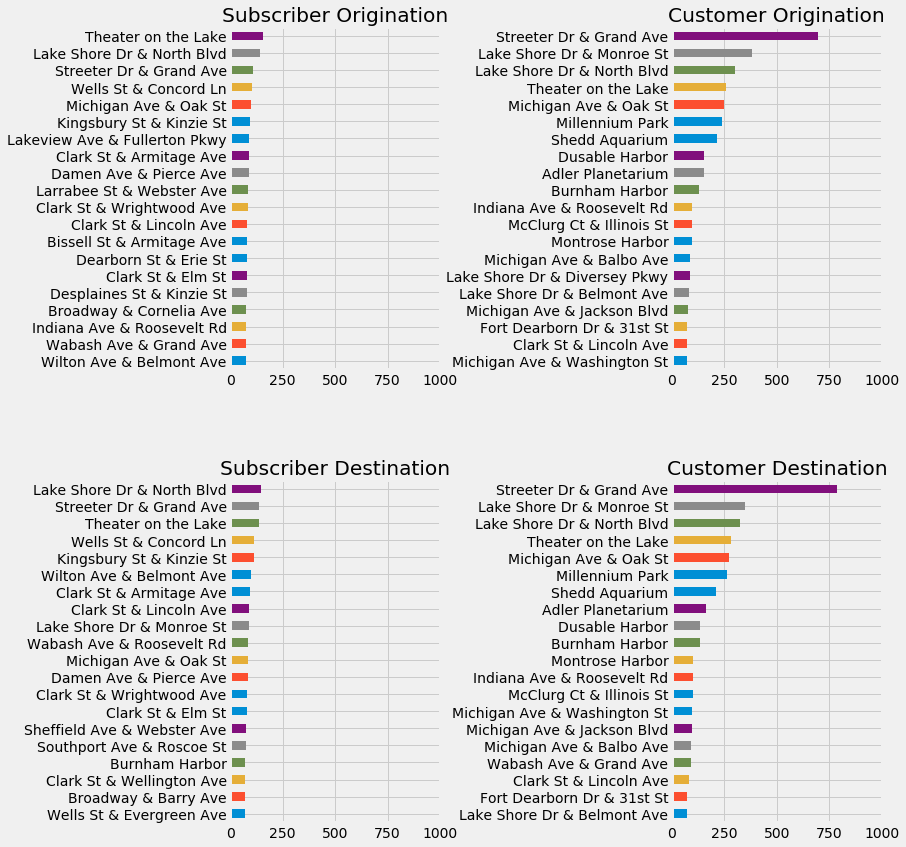

In [244]:
#Create grid for side by side
fig, axs = plt.subplots(2,2)
plt.xlim(0, 1600)
#Add padding to reduce overlap
plt.tight_layout(pad=0, w_pad=7, h_pad=1.0)

#Create new data set that only has the weekends.
array = ['Saturday', 'Sunday']
divvy_w = divvy.loc[divvy['weekday'].isin(array)]

ax1 = divvy_w[divvy_w['usertype']=="Subscriber"].from_station_name.value_counts().head(20).sort_values().plot(
      kind='barh'
    , title="Subscriber Origination" 
    , ax=axs[0,0]
    , figsize = (10,12))

ax2 = divvy_w[divvy_w['usertype']=="Subscriber"].to_station_name.value_counts().head(20).sort_values().plot(
      kind='barh'
    , title = "Subscriber Destination"
    , ax=axs[1,0]
    , figsize = (10,12))

ax3 = divvy_w[divvy_w['usertype']=="Customer"].from_station_name.value_counts().head(20).sort_values().plot(
      kind='barh'
    , title="Customer Origination"
    , ax=axs[0,1]
    , figsize = (10,12))

ax4 = divvy_w[divvy_w['usertype']=="Customer"].to_station_name.value_counts().head(20).sort_values().plot(
      kind='barh'
    , title = "Customer Destination"
    , ax=axs[1,1]
    , figsize = (10,12))


print(divvy_w[['usertype', 'tripduration']].groupby('usertype').describe())
print("Customer Median", np.median(divvy_w[divvy_w['usertype']=='Customer'].tripduration))
print("Subscriber Median", np.median(divvy_w[divvy_w['usertype']=='Subscriber'].tripduration))



graph_limits(1000)

### Summary

This exploration was meant to show the differences between Subscribers and Users of Divvy's bikesharing system. We've seen a clear difference between trip lenghts and popular stations used, as well as how Subscribers' usage shifts on the weeekend, where Customers' usage patterns stay largely the same.

The Pricing model is: 

Subscription $99/Annual (Unlimited 45 minute rides)

Customer Per Trip $3 (30 minute rides)

Customer Day Pass $15 (Unlimted 3 hour rides in 24 hour period)

Divvy should consdier increasing the price of Per Trip rides at 10 popular tourist stations on the weekend to generate more income without severly impacting locals. Also, because of the low usage of the non-loop stations by Customers, it might make sense for them to drop the per trip price in the outer neighborhoods to $1 on weekdays to encourage locals to try out the serivce without having a negative impact on reveneue. 

In the Future, I would like to get GPS coordinates for the stations and categorize them by neighborhood to get a better sense of how people use the system as well as exploring predictive modeling to implement surge pricing to increase revenues and solve bike distribution/rebalancing issues. 

